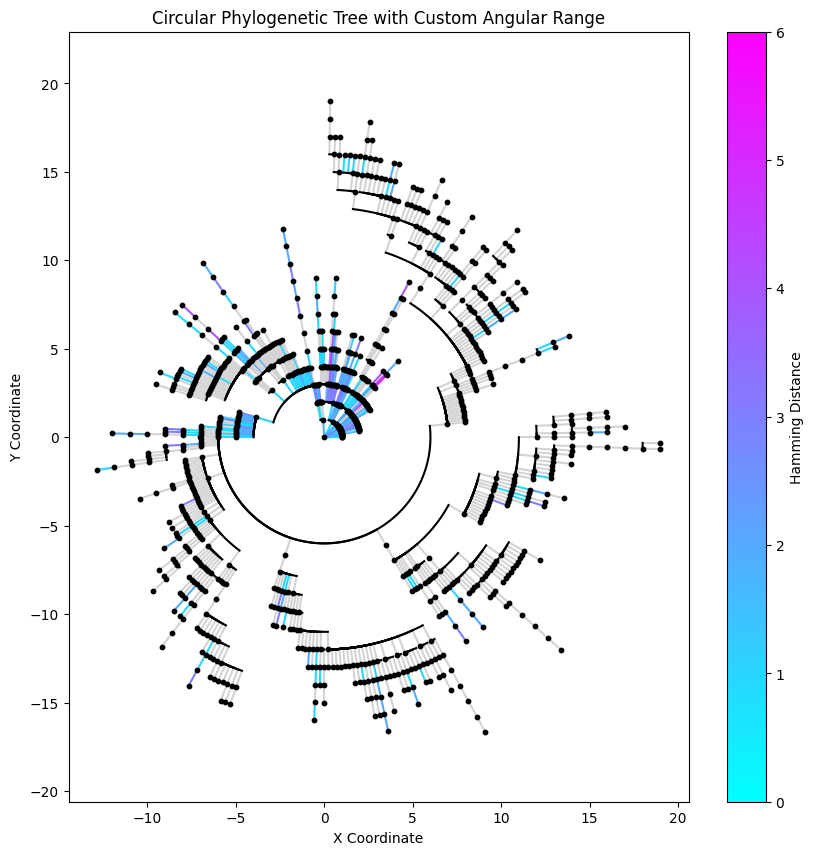

In [156]:
def plot_tree(self, max_generation=0, radius_offset=2, max_angle=450):
    import matplotlib.pyplot as plt
    import pandas as pd
    import networkx as nx
    import math
    import numpy as np

    from matplotlib.colors import ListedColormap, BoundaryNorm

    # Read the input CSV
    all_scores_df = pd.read_csv(self.ALL_SCORES_CSV)

    # Create a directed graph
    G = nx.DiGraph()
    G.add_node(0, sequence="X", generation=0) # WORKAROUND FOR DISTNACE!!!! ERRRRRRRRRRRRRRORRRR

    # Add nodes and edges
    for idx, row in all_scores_df.iterrows():
        if pd.isna(row['parent_index']):
            continue
        if row['generation'] + 1 > max_generation and max_generation != 0:
            continue

        G.add_node(idx + 1, sequence=row['sequence'], generation=row['generation'] + 1)

        if row['parent_index'] != "Parent":
            parent_idx = int(float(row['parent_index'])) + 1
            parent_sequence = all_scores_df.loc[all_scores_df.index == parent_idx - 1, 'sequence'].values[0]
            current_sequence = row['sequence']
            distance = hamming_distance(parent_sequence, current_sequence)
        else:
            parent_idx = 0
            distance = row['mutations']
        G.add_edge(parent_idx, idx + 1, hamming_distance=distance)

    # Calculate subtree sizes
    def calculate_subtree_sizes(graph, node, subtree_sizes):
        size = 1  # Count the current node
        for child in graph.successors(node):
            size += calculate_subtree_sizes(graph, child, subtree_sizes)
        subtree_sizes[node] = size
        return size

    subtree_sizes = {}
    calculate_subtree_sizes(G, 0, subtree_sizes)

    # Assign polar coordinates with grouping
    pos_polar = {}

    def assign_polar_positions(node, radius=0, angle_start=0, angle_range=max_angle):
        """
        Recursively assigns polar coordinates (radius, angle) to nodes, sorting branches by size.
        - `node`: Current node to position.
        - `radius`: Radial distance from the center (root node).
        - `angle_start`: Starting angle for this node's children.
        - `angle_range`: Total angular range for this node's children.
        """
        # Compute current node angle
        node_angle = angle_start
        pos_polar[node] = (radius, math.radians(node_angle))

        # Recurse for children, sorted by subtree size
        children = list(G.successors(node))
        if children:
            children.sort(key=lambda x: subtree_sizes[x])  # Sort children by subtree size
            num_children = len(children)
            child_angle_range = angle_range / num_children  # Subdivide angle range
            for i, child in enumerate(children):
                child_angle_start = angle_start + i * child_angle_range
                assign_polar_positions(
                    child, radius + 1, child_angle_start, child_angle_range
                )

    # Assign positions starting from the root
    assign_polar_positions(0, radius=0, angle_start=0, angle_range=max_angle)

    # Adjust angles to be uniformly distributed
    def adjust_uniform_angles(pos_polar):
        unique_angles = sorted({math.degrees(angle) for _, angle in pos_polar.values()})
        num_angles = len(unique_angles)
        uniform_angles = [max_angle / num_angles * i for i in range(num_angles)]

        angle_mapping = {unique_angles[i]: uniform_angles[i] for i in range(num_angles)}

        for node, (radius, angle) in pos_polar.items():
            pos_polar[node] = (radius, math.radians(angle_mapping[math.degrees(angle)]))

    adjust_uniform_angles(pos_polar)

    for node, (radius, angle) in pos_polar.items():
        if radius != 0:
            pos_polar[node] = (radius + radius_offset, angle)

    def polar_to_cartesian(radius, angle):
        return radius * math.cos(angle), radius * math.sin(angle)

    # Normalize Hamming distances
    hamming_distances = [G.edges[edge]['hamming_distance'] for edge in G.edges]
    min_hamming = 0
    max_hamming = max(hamming_distances)
    normalized_hamming = [(dist - min_hamming) / (max_hamming - min_hamming) for dist in hamming_distances]

    # Map normalized Hamming distances to colors
    base_cmap = plt.cm.cool  # Base colormap
    colors = ['lightgrey'] + [base_cmap(i) for i in np.linspace(0, 1, 256)]  # Black for 0
    custom_cmap = ListedColormap(colors)

    # Define normalization with boundaries (0 mutations as distinct)
    bounds = [0, 1e-5] + list(np.linspace(0.01, 1, 256))  # 1e-5 for 0 boundary
    norm = BoundaryNorm(bounds, custom_cmap.N)
    edge_colors = [custom_cmap(norm(dist)) for dist in normalized_hamming]

    fig, ax = plt.subplots(figsize=(10, 10))

    # Add colorbar for Hamming distances
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(vmin=0, vmax=max_hamming))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)  # Attach the colorbar to the specific axes
    cbar.set_label('Hamming Distance')

    for edge_idx, edge in enumerate(G.edges):
        start, end = edge
        r0, theta0 = pos_polar[start]
        r1, theta1 = pos_polar[end]

        arc_radius = r1 - 1
        arc_theta = np.linspace(theta0, theta1, 100)
        arc_x = arc_radius * np.cos(arc_theta)
        arc_y = arc_radius * np.sin(arc_theta)
        plt.plot(arc_x, arc_y, color="k", zorder=2)

        x_mid2, y_mid2 = polar_to_cartesian(r1 - 1.0, theta1)
        x1, y1 = polar_to_cartesian(r1, theta1)
        plt.plot([x_mid2, x1], [y_mid2, y1], color=edge_colors[edge_idx], zorder=1)

    pos_cartesian = {node: polar_to_cartesian(r, theta) for node, (r, theta) in pos_polar.items()}
    x_vals, y_vals = zip(*pos_cartesian.values())
    plt.scatter(x_vals, y_vals, s=10, c="k", zorder=3)

    plt.title("Circular Phylogenetic Tree with Custom Angular Range")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(False)
    plt.axis('equal')
    plt.show()

from types import SimpleNamespace
import pandas as pd
import networkx as nx
from helper_001 import *

# Create a simple object
self = SimpleNamespace()
self.ALL_SCORES_CSV = "all_scores.csv"

plot_tree(self, max_generation=0, radius_offset=0, max_angle=450)
